In [ ]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install datasets
from datasets import load_dataset
from torch.utils.data import DataLoader

data_dir = "/content/drive/MyDrive/Inter_A2DS/New cropped"

# load dataset
train_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "training_set"), split="train")
test_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "testing_set"), split="train")

# label2idx and idx2label
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
# split train, val
splits = train_ds.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_ds, val_ds = splits["train"], splits["test"]
print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
print("Test", test_ds)
print("Num labels", len(label2id))
print("Label2Idx", label2id)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Resolving data files:   0%|          | 0/3992 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-489cb83184054eed/0.0.0/e872d3ec27c6c200a8881a4af52930df7eca3372b19aa4d0f5db74a2fded8141. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/999 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-a84f9e9051b7c00b/0.0.0/e872d3ec27c6c200a8881a4af52930df7eca3372b19aa4d0f5db74a2fded8141. Subsequent calls will reuse this data.
Features {'image': Image(decode=True, id=None), 'label': ClassLabel(num_classes=5, names=['Heart', 'Oblong', 'Oval', 'Round', 'Square'], id=None)}
Train Dataset({
    features: ['image', 'label'],
    num_rows: 3592
})
Validation Dataset({
    features: ['image', 'label'],
    num_rows: 400
})
Test Dataset({
    features: ['image', 'label'],
    num_rows: 999
})
Num labels 5
Label2Idx {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}


In [ ]:
!pip install transformers
from transformers import AutoFeatureExtractor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose([
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ])

_val_transforms = Compose([
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 53.3 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

In [ ]:
feature_extractor.image_mean, feature_extractor.image_std
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

In [ ]:
###########  Dataloader  ##############
batchsize=128
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=batchsize)

In [ ]:
############# Deffine the model #############
from transformers import SwinForImageClassification, SwinConfig

config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True
)

Downloading:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
metric_name = "accuracy"
args = TrainingArguments(
    f"faceshape",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=70,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

### load Metric
from datasets import load_metric
import numpy as np

metric = load_metric(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


In [ ]:
############# TRAINER ##############
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3592
  Num Epochs = 70
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7910


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.451045,0.347500
2,No log,1.267755,0.467500
3,No log,1.162267,0.545000
4,No log,1.068050,0.572500
5,1.359500,1.004744,0.630000
6,1.359500,0.931774,0.652500
7,1.359500,0.841813,0.672500
8,1.359500,0.823920,0.657500
9,0.991400,0.801758,0.702500
10,0.991400,0.737639,0.722500


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to faceshape/checkpoint-113
Configuration saved in faceshape/checkpoint-113/config.json
Model weights saved in faceshape/checkpoint-113/pytorch_model.bin
Feature extractor saved in faceshape/checkpoint-113/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to faceshape/checkpoint-226
Configuration saved in faceshape/checkpoint-226/config.json
Model weights saved in faceshape/checkpoint-226/pytorch_model.bin
Feature extractor saved in faceshape/checkpoint-226/preprocessor_config.json
Deleting older checkpoint [faceshape/checkpoint-113] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to faceshape/checkpoint-339
Configuration saved in faceshape/checkpoint-339/config.json
Model weights saved in faceshape/checkpoint-339/pytorch_model.bin
Feature extractor sa

TrainOutput(global_step=7910, training_loss=0.48735913880706283, metrics={'train_runtime': 7001.7102, 'train_samples_per_second': 35.911, 'train_steps_per_second': 1.13, 'total_flos': 6.250313773143982e+18, 'train_loss': 0.48735913880706283, 'epoch': 70.0})

In [ ]:
### Validation ######
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 400
  Batch size = 32


{'eval_loss': 0.5451556444168091,
 'eval_accuracy': 0.855,
 'eval_runtime': 5.3181,
 'eval_samples_per_second': 75.215,
 'eval_steps_per_second': 2.444,
 'epoch': 70.0}

In [ ]:
#### PREDICT #########
outputs = trainer.predict(test_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names

***** Running Prediction *****
  Num examples = 999
  Batch size = 32


{'test_loss': 0.5268678069114685, 'test_accuracy': 0.8568568568568569, 'test_runtime': 288.2281, 'test_samples_per_second': 3.466, 'test_steps_per_second': 0.111}


              precision    recall  f1-score   support

       Heart       0.84      0.83      0.84       199
      Oblong       0.89      0.94      0.91       200
        Oval       0.84      0.78      0.81       200
       Round       0.82      0.88      0.85       200
      Square       0.88      0.86      0.87       200

    accuracy                           0.86       999
   macro avg       0.86      0.86      0.86       999
weighted avg       0.86      0.86      0.86       999



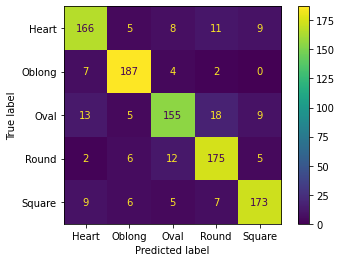

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()